## **HYBRID ARMA-LSTM**

CONSUMPTION (ENERGY GOODS &
SERVICES) IN U.S.

The dataset contains observations collected from January 1959 to June 2023, offering a detailed
view of changes in consumer expenditure patterns. It consists of 774 data points, with each
observation representing a month. The two main variables in the dataset include the date and
the amount of personal consumption expenditures dedicated to energy goods and services.
The aim of this project is to compare traditional Arma time series model to the hybrid arma lstm model.

In [64]:
library(keras)
library(tensorflow)
library(longmemo)
library(ggplot2)
library(ggpubr)

In [18]:
suppressMessages(devtools::source_gist(filename = "helper_funcs.R",
                                       id = "https://gist.github.com/Letmode/8c842b722ab31210ad6df64ef786a8c2"))

In [8]:
set_random_seed(10000)


#loading in data
data <- read.table("DNRGRC1M027SBEA.csv", sep = ",", header = TRUE)
colnames(data)

[1] "DATE"            "DNRGRC1M027SBEA"

In [9]:
#checking minimum requirement
str(data)

'data.frame':	774 obs. of  2 variables:
 $ DATE           : chr  "1959-01-01" "1959-02-01" "1959-03-01" "1959-04-01" ...
 $ DNRGRC1M027SBEA: num  22.6 22.7 22.7 22.5 22.8 23 23 23.1 22.9 23.5 ...


In [10]:
#cleaning data to remove non-numeric variables, NAs & easily readble col names
sum(is.na(data))
data <- data[rowSums(is.na(data)) == 0, ]

[1] 0

In [11]:
 # statistical description
 summary(data)

     DATE           DNRGRC1M027SBEA 
 Length:774         Min.   : 22.50  
 Class :character   1st Qu.: 73.42  
 Mode  :character   Median :226.75  
                    Mean   :278.06  
                    3rd Qu.:495.32  
                    Max.   :885.80  

# **ARMA MODEL**

In [12]:
Y0 = data$DNRGRC1M027SBEA #### always positive
n0 = length(Y0)
Year = 1:n0
# First stage
# obtain conditional mean with ARMA(1, 1)
p = 1
q = 1

In [19]:
n_te = 100
n_tr = n0 - n_te
nndata = dataprep_nn_arma(Y0, ntrain = n_tr, p.max = 1, q.max = 1, fixed = TRUE)
nndata$m_arma


Call:
arima(x = y_arma - mutrain, order = c(p, 0, q))

Coefficients:
         ar1     ma1  intercept
      0.9987  0.1286     2.9632
s.e.  0.0015  0.0388   209.6628

sigma^2 estimated as 118:  log likelihood = -2567.3,  aic = 5142.6

# **BUILDING THE LSTM MODEL OFF THE ARMA MODEL RESIDUALS.**

In [20]:
Y_te = nndata$Ytest # standardized test data (minmax method)
Y0_te = nndata$Y0test # original test data Y0
mu_tr = nndata$Ytrain_arma # estimated cond. mean from ARMA(1, 1) training data
mu_te = nndata$Ytest_arma # estimated cond. mean from ARMA(1, 1) test data
mu = c(mu_tr, mu_te)
eps_t = Y0 - mu # residuals of whole time series

In [21]:
hybriddata = dataprep_nn_arma(eps_t, ntrain = n_tr, p.max = p, q.max = q, fixed = TRUE)
X_tr = hybriddata$Xtrain
X_te = hybriddata$Xtest
Y_tr = hybriddata$Ytrain
Y_te = hybriddata$Ytest

In [22]:
dim(X_tr) = c(dim(X_tr), 1)

pq = p + q

In [31]:
model <- keras_model_sequential() %>%
  layer_lstm(units = 10,
             batch_input_shape = c(1, pq, 1),
             stateful = TRUE) %>%
  layer_dense(units = 1, activation = "relu")

model %>%
  compile(loss = 'mse', optimizer = 'adam', metrics = 'mae')

summary(model)

Model: "sequential_1"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 lstm_1 (LSTM)                      (1, 10)                         480         
 dense_1 (Dense)                    (1, 1)                          11          
Total params: 491 (1.92 KB)
Trainable params: 491 (1.92 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


LSTM (10) is therefore built on the residual of the conditional mean of ARMA (1,1). LSTM
(10) refers to a neural network architecture with 10 units (memory cells) or nodes in the layer.
The LSTM is therefore designed to handle sequential data by capturing long-term dependencies
with 10 as the number of units within the layer.

In [32]:
model %>% fit(
  x = X_tr,
  y = Y_tr,
  batch_size = 1,
  epochs = 5,
  verbose = 1,
  shuffle = FALSE
)

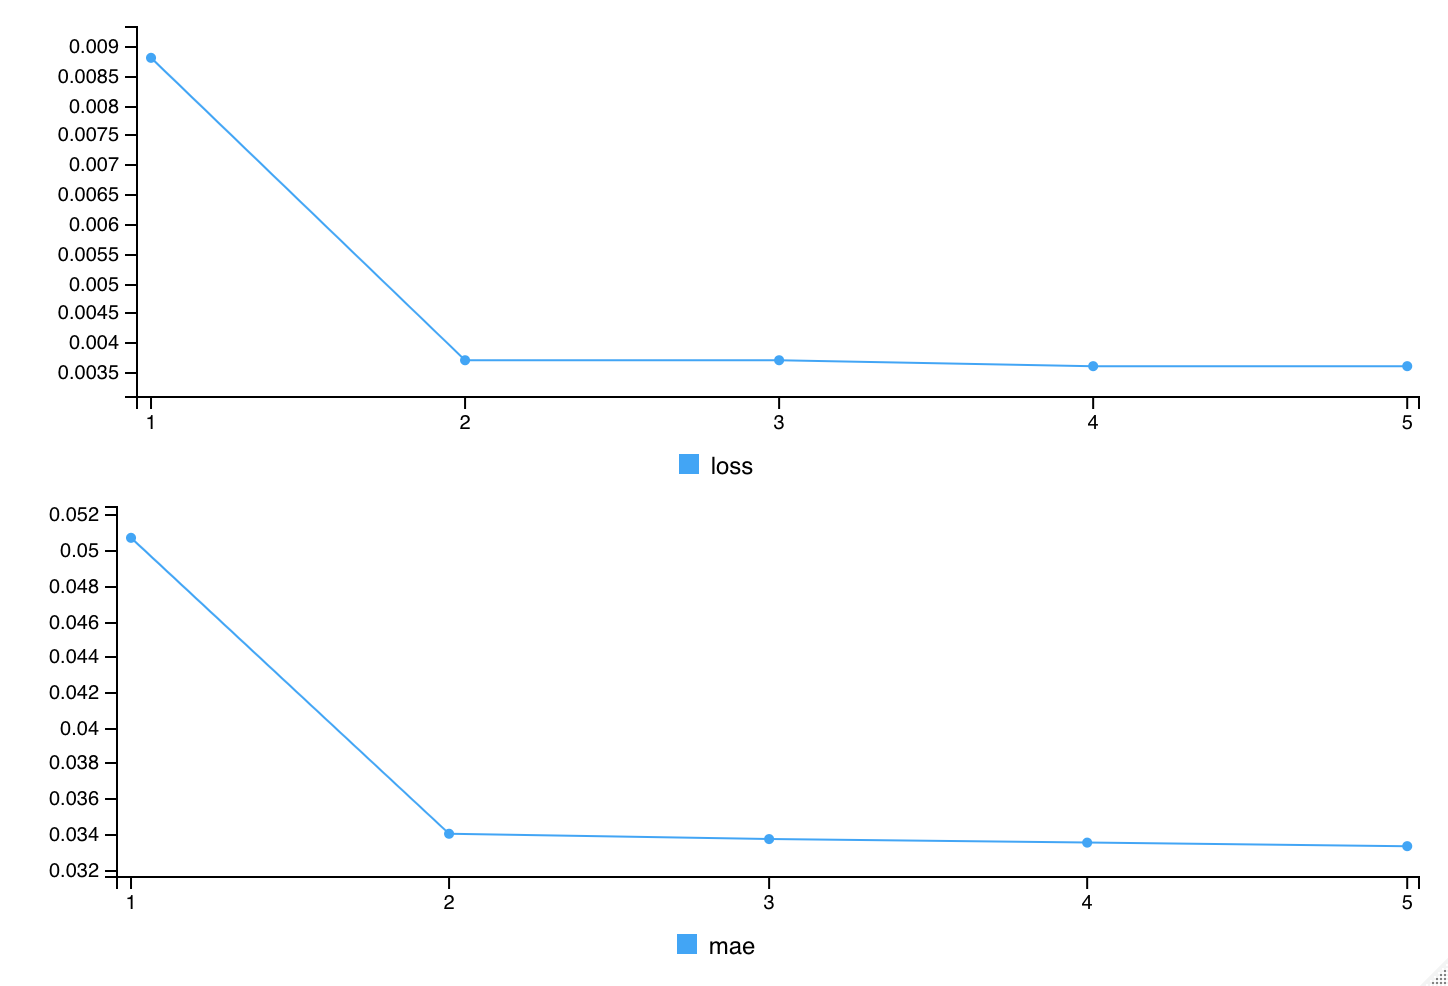

In our case, the model was
trained for 5 epochs with a batch size of 1 meaning that the model is updated after each
individual data point while the training data wasn't shuffled before each epoch. Analysing
Figure 1 reveals a conspicuous trend, during the initial epochs, both the loss and Mean Absolute
Error (MAE) experience a substantial reduction before plateauing. The loss fell from 0.0088 to
0.0037 and MAE 0.0507 to 0.0340 between epoch 1 and epoch 2, and afterward showed a
gradual decline in loss and MAE as the epochs increased, making epoch 5 being selected as an
optimal choice for minimizing loss at 0.0036 and MAE at 0.0333.

## **BUILDING THE HYBRID MODEL**

The data is standardized back to its original form so the hybrid model to estimate the relative
coefficients. The standardized data in its original form plus the estimated conditional mean
from ARMA (1, 1) test data gives us the hybrid LSTM ARMA model.

In [33]:
X_pred = array(X_te, dim = c(dim(X_te), 1))
pred_out <- model %>%
  predict(X_pred, batch_size = 1)

In [34]:
pred_out = pred_out * hybriddata$Ydiff + hybriddata$Ymin

In [35]:
pred_out = pred_out + mu_te # hybrid conestimates

In [36]:
###plotting the graphs
Year.og = Year
Year.te = Year[(n_tr + 1):n0]
df_og <- as.data.frame(cbind(Year.og, Y0))
df_fcs <- as.data.frame(cbind(Year.te, pred_out, Y0_te, nndata$Ytest_arma))
colnames(df_fcs) <- c("Year", "pred.te", "real_data", "pred.arma")

In [38]:
plot_data = ggplot(df_og) +
  geom_line(aes(x = Year.og, y = Y0), color = "black") +
  labs(title = "Personal consumption expenditures:Energy goods and services", y = "", x = "Year") +
  theme(legend.text = element_text(size = 12), plot.title = element_text(size = 14),
        axis.title = element_text(size = 12))

In [42]:
plot_fcs = ggplot(df_fcs) +
  geom_line(aes(x = Year, y = real_data, color = "og")) +
  geom_line(aes(x = Year, y = pred.te, color = "lstm")) +
  geom_line(aes(x = Year, y = pred.arma, color = "arma")) +
  labs(title = "Hybrid ARMA-LSTM (10) predictions", y = "") +
  scale_color_manual("", values = c("og" = "black", "lstm" = "red", "arma" = "blue"),
                     labels = c("og" = "Test data", "lstm" = "hybrid LSTM-preds", "arma" = "ARMA-preds")) +
  theme(legend.text = element_text(size = 12), plot.title = element_text(size = 14),
        axis.title = element_text(size = 12), legend.position = c(0.85, 0.85))

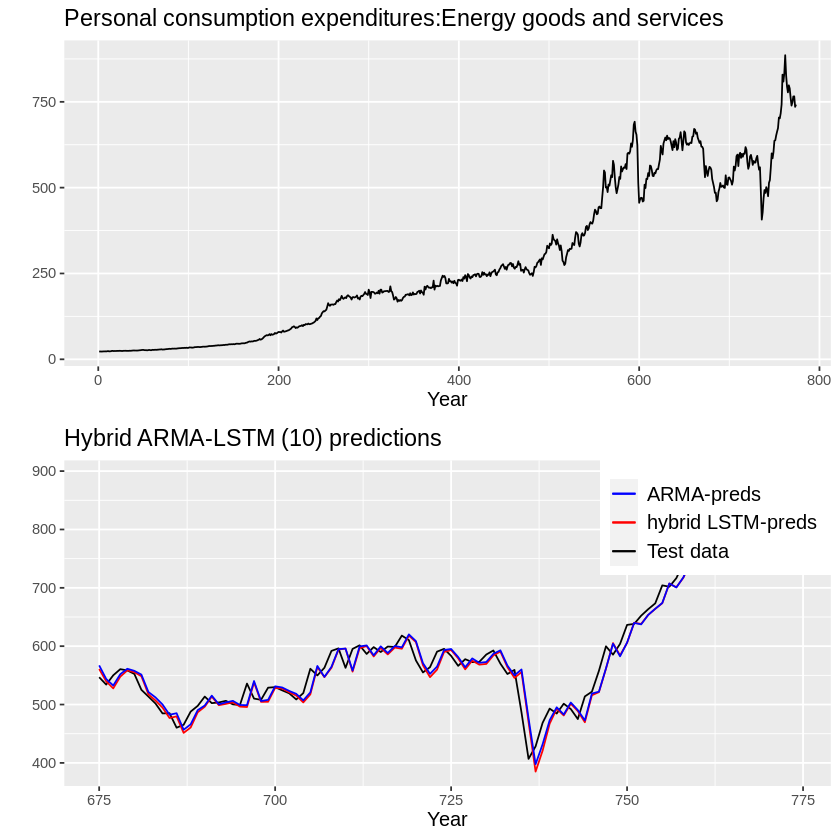

In [63]:
ggpubr::ggarrange(plot_data, plot_fcs, ncol = 1)

In [65]:
##model evaluation
ASE_lstm = ASE_calc(Y0_te, pred_out)
ASE_arma = ASE_calc(Y0_te, nndata$Ytest_arma)
AAE_lstm = AAE_calc(Y0_te, pred_out)
AAE_arma = AAE_calc(Y0_te, nndata$Ytest_arma)
CCP_lstm = cor(Y0_te, pred_out)
CCP_arma = cor(Y0_te, nndata$Ytest_arma)
eval_crits = data.frame("ASE" = c(ASE_lstm, ASE_arma), "AAE" = c(AAE_lstm, AAE_arma),
                        "CCP" = c(CCP_lstm, CCP_arma))
rownames(eval_crits) = c("LSTM", "ARMA")
eval_crits

,ASE,AAE,CCP
,<dbl>,<dbl>,<dbl>
LSTM,604.7233,18.79485,0.9732486
ARMA,581.8815,18.35523,0.9732229


The ASE measures the average of the squared differences between the actual and predicted
values. In this case, for the LSTM model, the ASE is 604.7233, and for the ARMA model, it's
581.8815. This indicates how far, on average, the predictions of each model are from the actual
values. A lower ASE suggests better predictive accuracy. While the AAE calculates the average
of the absolute differences between the actual and predicted values. In our data, the AAE for
the LSTM model is 18.79485, and for the ARMA model, it's 18.35523. It provides an idea of
the average magnitude of the errors in the predictions. Like ASE, a lower AAE indicates better
predictive accuracy. Both models CCP (Concordance Correlation Coefficient) are
approximately similar.

#**Increasing complexities of neural network**

In [66]:
### increasing the number of hidden layers and neurons
model2 <- keras_model_sequential() %>%
  layer_lstm(units = 100,
             batch_input_shape = c(1, pq, 1),
             stateful = TRUE,
             return_sequences = TRUE) %>%
  layer_lstm(units = 50,
             stateful = TRUE) %>%
  layer_dense(units = 1, activation = "relu")

model2 %>%
  compile(loss = 'mse', optimizer = 'adam', metrics = 'mae')

summary(model2)

Model: "sequential_2"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 lstm_3 (LSTM)                      (1, 2, 100)                     40800       
 lstm_2 (LSTM)                      (1, 50)                         30200       
 dense_2 (Dense)                    (1, 1)                          51          
Total params: 71051 (277.54 KB)
Trainable params: 71051 (277.54 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________________________


LSTM (100,50) was therefore built on the residual conditional mean of ARMA (1,1). LSTM
(100, 50) signifies an LSTM layer with 100 LSTM units or cells on the first layer and 50 units
or neurons on the second.

In [73]:
model2 %>% fit(
  x = X_tr,
  y = Y_tr,
  batch_size = 1,
  epochs = 10,
  verbose = 1,
  shuffle = FALSE
)

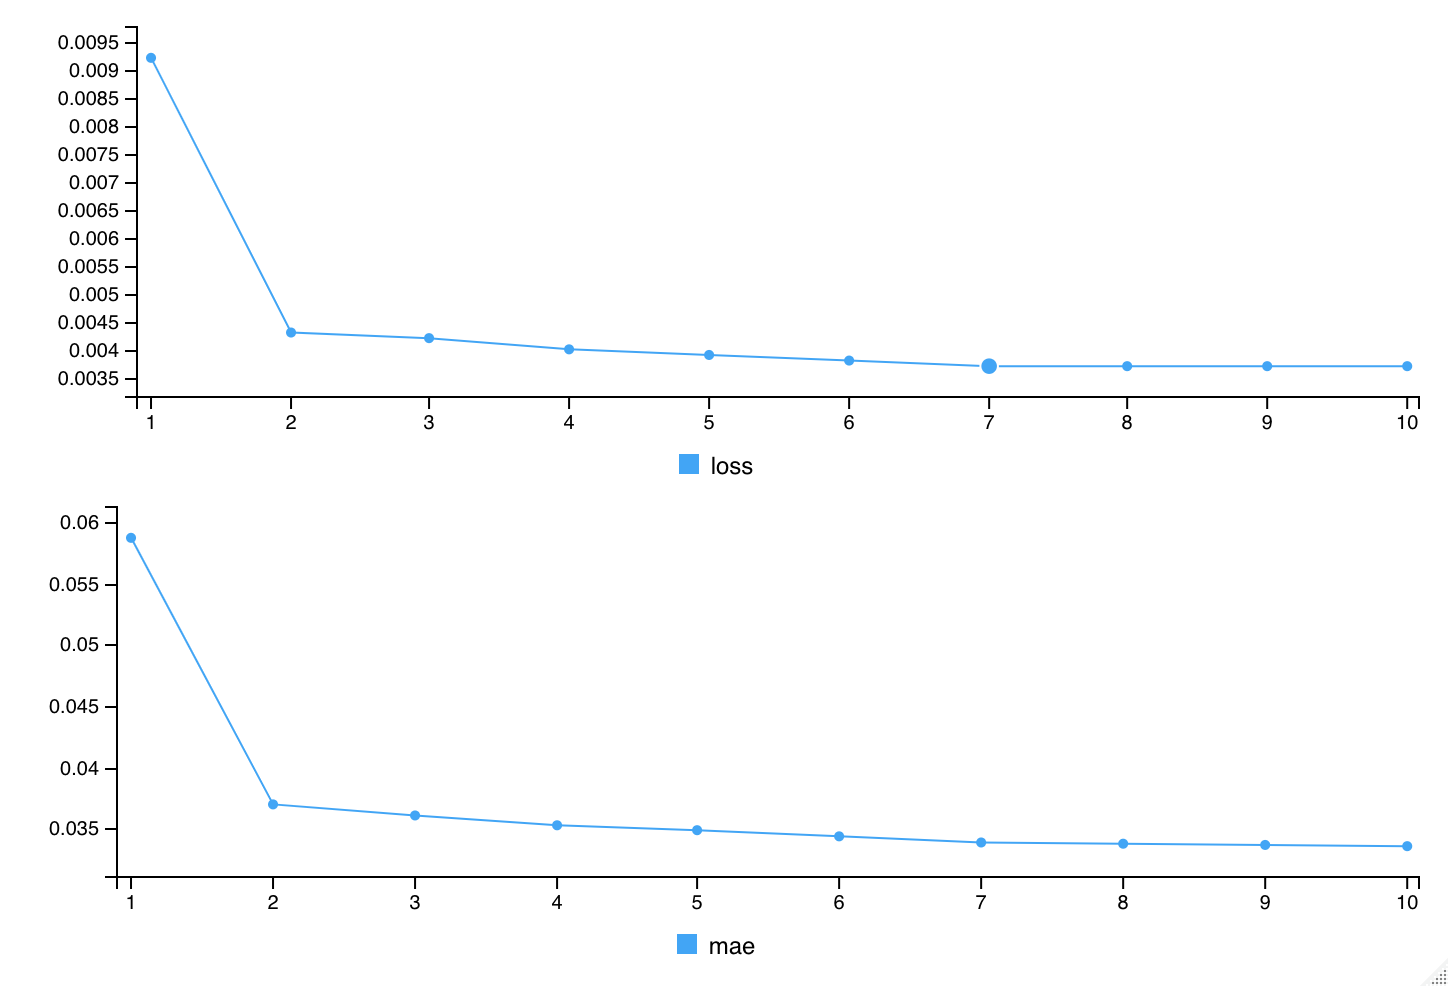

The Figures illustrate the fact that the larger the epochs, the lower the loss and MAE. Therefore, a
deep fall from the first epoch to the second epoch, the loss and MAE gradually fall or approach
zero and it can be optimized at the tenth epoch with the lowest loss of 0.0037 and MAE of
0.0336. This is not far from the optimal epoch 5 for the LSTM (10) built earlier with a loss of
0.0036 and MAE of 0.0333.

In [68]:
pred_out <- model2 %>%
  predict(X_pred, batch_size = 1)

In [69]:
pred_out = pred_out * hybriddata$Ydiff + hybriddata$Ymin
pred_out = pred_out + mu_te # hybrid conestimates

In [70]:
df_fcs <- as.data.frame(cbind(Year.te, pred_out, Y0_te, nndata$Ytest_arma))
colnames(df_fcs) <- c("Year", "pred.te", "real_data", "pred.arma")

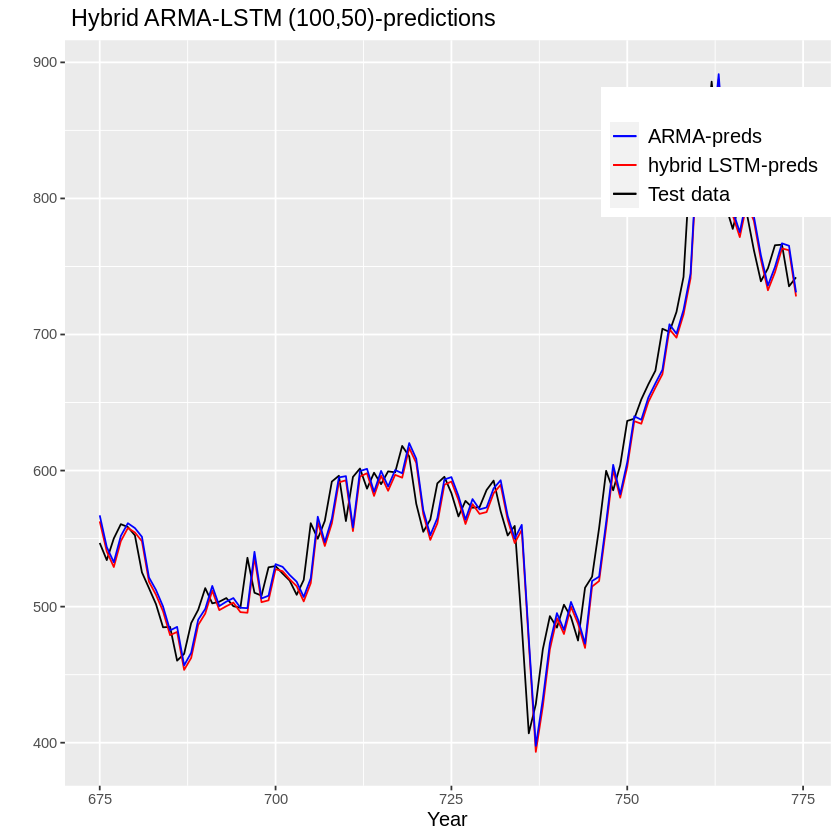

In [71]:
plot_fcs = ggplot(df_fcs) +
  geom_line(aes(x = Year, y = real_data, color = "og")) +
  geom_line(aes(x = Year, y = pred.te, color = "lstm")) +
  geom_line(aes(x = Year, y = pred.arma, color = "arma")) +
  labs(title = " Hybrid ARMA-LSTM (100,50)-predictions", y = "") +
  scale_color_manual("", values = c("og" = "black", "lstm" = "red", "arma" = "blue"),
                     labels = c("og" = "Test data", "lstm" = "hybrid LSTM-preds", "arma" = "ARMA-preds")) +
  theme(legend.text = element_text(size = 12), plot.title = element_text(size = 14),
        axis.title = element_text(size = 12), legend.position = c(0.85, 0.85))
plot_fcs

In [72]:
##Evaluation
ASE_lstm = ASE_calc(Y0_te, pred_out)
AAE_lstm = AAE_calc(Y0_te, pred_out)
CCP_lstm = cor(Y0_te, pred_out)

eval_crits = data.frame("Evaluation metric" = c(ASE_lstm,AAE_lstm, CCP_lstm))
rownames(eval_crits) = c("ASE", "AAE", "CCP")
eval_crits

,Evaluation.metric
,<dbl>
ASE,607.2505219
AAE,18.8057346
CCP,0.9732246


It can be noticed that increasing the complexities of the neural network didn’t actually help as
both ASE and AAE was an increase with the CCP slightly falling or approximately the same.
The traditional ARMA (1,1) outperforms them all.